## Лабораторная работа № 2
-----

Необходимо реализовать фильтр калмана по сигма точкам для приведенного задания.

Задача: найти положение в 1D пространстве, только в отличии от
примера 1(где измеряли изменение положения по данным GPS)
используем данные с камеры, измеряя высоту отдаленных
ориентиров относительно горизонта.<br />
Важно!
1.) Сохраним ту же модель линейного движения, что и в исходном
примере, и предположим, что мы знаем высоту ориентира и его
положение в глобальной системе координат.
2.) Поскольку наш датчик измеряет угол, наша измерительная
модель имеет нелинейную зависимость от положения
движущегося объекта.

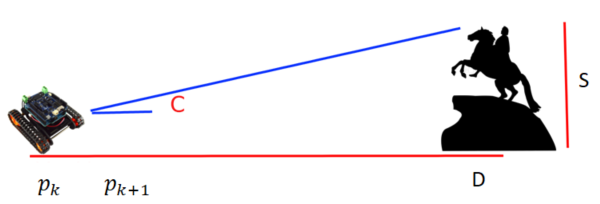

### Исходные данные 
Объект характеризуется
положением и скоростью.
Управление: по ускорению.
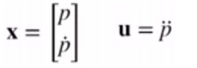

Модель движения
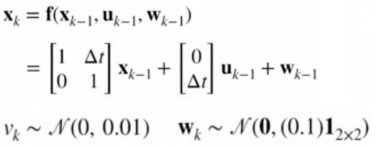

Модель измерения
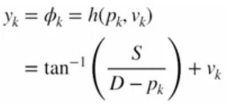

Необходимо найти положение объекта в момент
времени 𝒌 + 𝟏, при ∆𝒕 = 𝟎. 𝟓 сек
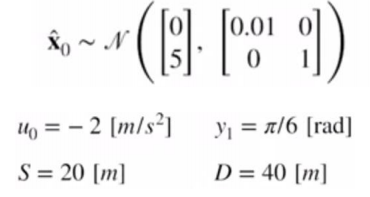

## Начнем с предсказания

In [2]:
import numpy as np
from numpy.linalg import inv, cholesky

In [3]:
# среднее в момент времени 0
x_0 = np.array([[0 , 5]])

# ковариация в момент времени 0
P_0 = np.array([[0.01 , 0],
                [0, 1]])

# ковариация модели движения в момент времени 0
Q_0 = np.array([[0.1 , 0],
                [0, 0.1]]) 

# ковариация модели измерения в момент времени 0
R_0 = 0.01 
u_0 = -2
y_1 = np.pi/6
S = 20
D = 40
dt = 0.5

# 
def motion_iterate(dt, x_k, u_k):
    """
    example inputs:
    dt = 0.5
    x_k = 0
    u_k = -2
    """
    # motion model
    x_matrix = np.array([[1, dt], [0, 1]])
    u_matrix = np.array([[0], [dt]])
    x_k = x_matrix.dot(x_k.T) + u_k*u_matrix
    return x_k.T

Для N мерного распределения необходимо взять 2N+1 сигма точку.

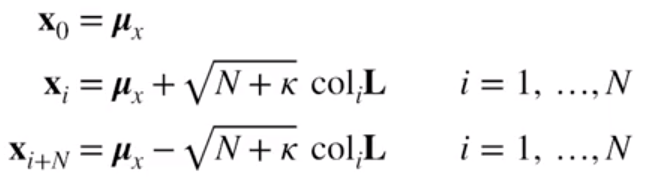

In [4]:
# разложение Холецкого для ковариационной матрицы

# размерность распределения
N = 2 

# каппа (значение для нормального распределения)
ka = 3 - N 

# в формуле обозначено как L
hol = cholesky(P_0) 
print(hol)

# находим сигма-точки
sigma_list = []
sigma_list.append(x_0)

# слева
for i in range(0, N):
    sigma = x_0 - np.sqrt(N + ka)*hol[i]
    sigma_list.append(sigma)

# справа
for i in range(0, N):
    sigma = x_0 + np.sqrt(N + ka)*hol[i]
    sigma_list.append(sigma)
    
print(sigma_list)

[[0.1 0. ]
 [0.  1. ]]
[array([[0, 5]]), array([[-0.17320508,  5.        ]]), array([[0.        , 3.26794919]]), array([[0.17320508, 5.        ]]), array([[0.        , 6.73205081]])]


In [5]:
# пропускаем сигма-точки через нелинейную функцию (модель движения),
# чтобы получить сигма-точки для момента времени k
sigma_transformed = np.zeros((len(sigma_list), 2))
for i, sigma in enumerate(sigma_list):
    sigma_transformed[i] = motion_iterate(dt, sigma_list[i], u_0)

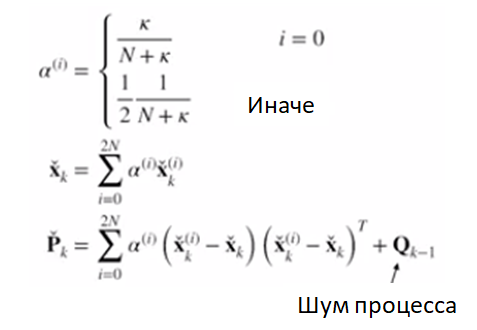

In [6]:
# считаем выходное (предсказанное) распределение, характризующееся средним и ковариацией
x_new = np.array([[0.0], [0.0]])
P_new = np.array([[0.0, 0.0],[0.0, 0.0]])

# коэффициенты a_i
a_list = []

for i in range(0,len(sigma_transformed)):
    if i == 0:
        a = ka/(N + ka)
        a_list.append(a)
    else:
        a = 1/2*(1/(N + ka))
        a_list.append(a)
        
    #среднее нового распределения
    x_new[0] = x_new[0] + a*sigma_transformed[i, 0]
    x_new[1] = x_new[1] + a*sigma_transformed[i, 1]

print(a_list)

# ковариация нового распределения
for i in range(0,len(sigma_transformed)):
    P_new[0][0] = a_list[i]*((sigma_transformed[i, 0] - x_new[0]).dot((sigma_transformed[i, 0] - x_new[0]).T)) + Q_0[0][0]
    P_new[1][1] = a_list[i]*((sigma_transformed[i, 1] - x_new[1]).dot((sigma_transformed[i, 1] - x_new[1]).T)) + Q_0[1][1]

print("The new mean = ", x_new)
print("The new covariance = ", P_new)

[0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]
The new mean =  [[2.5]
 [4. ]]
The new covariance =  [[0.225 0.   ]
 [0.    0.6  ]]


## Теперь, зная предсказание, после измерения можно сделать поправку
аналогичная процедура, только на этот раз с нелинейной моделью измерения
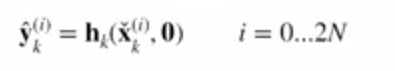

In [7]:
# разложение нового P_new
hol = cholesky(P_new) 
print(hol)

# аналогично находим сигма-точки для x_new
x_new_r = x_new.reshape(1,2)
sigma_list_new = []
sigma_list_new.append(x_new_r)

for i in range(0, N):
    sigma = x_new_r - np.sqrt(N + ka)*hol[i]
    sigma_list_new.append(sigma)

for i in range(0, N):
    sigma = x_new_r + np.sqrt(N + ka)*hol[i]
    sigma_list_new.append(sigma)
    
print(sigma_list_new)

[[0.47434165 0.        ]
 [0.         0.77459667]]
[array([[2.5, 4. ]]), array([[1.67841616, 4.        ]]), array([[2.5       , 2.65835921]]), array([[3.32158384, 4.        ]]), array([[2.5       , 5.34164079]])]


In [8]:
def measure_iterate(S,D,pk):
    """
    example inputs:
    S = 0.5
    D = 0
    p_k = -2
    """
    # motion model 
    y_k = np.arctan(S/(D-pk))
    return y_k

# аналогично прогоняем через модель измерения
sigma_transformed_new = np.zeros((len(sigma_list_new), 2))
for i, sigma in enumerate(sigma_list_new):
    sigma_transformed_new[i] = measure_iterate(S, D, sigma_list_new[i])

Теперь считаем среднюю и ковариацию

In [9]:
# среднее нового распределения
y_new = np.array([[0.0], [0.0]])
P_y_new = np.array([[0.0, 0.0],[0.0, 0.0]])

for i in range(0,len(sigma_transformed_new)):

    y_new[0] = y_new[0] + a_list[i]*sigma_transformed_new[i, 0]
    y_new[1] = y_new[1] + a_list[i]*sigma_transformed_new[i, 1]


# ковариация нового распределения
for i in range(0,len(sigma_transformed_new)):
    P_y_new[0][0] = a_list[i]*((sigma_transformed_new[i, 0] - y_new[0]).dot((sigma_transformed_new[i, 0] - y_new[0]).T)) + R_0
    P_y_new[1][1] = a_list[i]*((sigma_transformed_new[i, 1] - y_new[1]).dot((sigma_transformed_new[i, 1] - y_new[1]).T)) + R_0

print("The new mean = ", y_new)
print("The new covariance = ", P_y_new)

The new mean =  [[0.49000906]
 [0.50724878]]
The new covariance =  [[0.01       0.        ]
 [0.         0.01004338]]


## Объединяем данные

Считаем  кросс ковариацию, усилитель калмана и получаем финальное значение оценки


In [10]:
P_xy = np.array([[0.0, 0.0],[0.0, 0.0]])

for i in range(0, len(sigma_transformed_new)):
    for i in range(0,len(sigma_transformed_new)):
        P_xy[0][0] = a_list[i]*((sigma_transformed[i, 0] - x_new[0]).dot((sigma_transformed_new[i, 0] - y_new[0]).T))
        P_xy[1][1] = a_list[i]*((sigma_transformed[i, 1] - x_new[1]).dot((sigma_transformed_new[i, 1] - y_new[1]).T))
        
print(P_xy)

[[-7.46720119e-06  0.00000000e+00]
 [ 0.00000000e+00  4.65728058e-03]]


In [11]:
# усилитель
K = P_xy.dot(inv(P_y_new))
K = np.array([[K[0][0]], [K[1][1]]])
K

array([[-0.00074672],
       [ 0.46371643]])

In [12]:
# финальная оценка после корректировки
x_1 = x_new + K * (y_1 - y_new)
print(x_1)

[[2.49997492]
 [4.00758176]]


## Вывод
В результате выполнения лабораторной работы №2 был реализован фильтр Калмана по сигма-точкам с целью определения положения объекта в момент времени k. За истинное значение было принято полученное предсказание, которое впоследствии также использовалось для внесения поправки в измерения при определении нового положения объекта. По ходу решения видно, что финальное положение объекта соотносится с полученным предсказанием, что позволяет сделать вывод о том, что расчёты были
произведены верно.
